<a href="https://colab.research.google.com/github/neuromodgames/HeadDrive-Unity/blob/main/BehaviouralCloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!git clone https://github.com/neuromodgames/SelfDrivingCar/

fatal: destination path 'SelfDrivingCar' already exists and is not an empty directory.


In [100]:
!ls SelfDrivingCar/Track1/Data

driving_log.csv  IMG


In [101]:
!pip3 install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [103]:
datadir = 'SelfDrivingCar/Track1/Data/'
columns = ['center', 'left', 'right','steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  \
0  C:\NMG\Data\IMG\center_2022_07_20_11_46_27_428.jpg   
1  C:\NMG\Data\IMG\center_2022_07_20_11_46_27_529.jpg   
2  C:\NMG\Data\IMG\center_2022_07_20_11_46_27_635.jpg   
3  C:\NMG\Data\IMG\center_2022_07_20_11_46_27_737.jpg   
4  C:\NMG\Data\IMG\center_2022_07_20_11_46_27_838.jpg   

                                                left  \
0   C:\NMG\Data\IMG\left_2022_07_20_11_46_27_428.jpg   
1   C:\NMG\Data\IMG\left_2022_07_20_11_46_27_529.jpg   
2   C:\NMG\Data\IMG\left_2022_07_20_11_46_27_635.jpg   
3   C:\NMG\Data\IMG\left_2022_07_20_11_46_27_737.jpg   
4   C:\NMG\Data\IMG\left_2022_07_20_11_46_27_838.jpg   

                                                right  steering  throttle  \
0   C:\NMG\Data\IMG\right_2022_07_20_11_46_27_428.jpg  0.0       0.0        
1   C:\NMG\Data\IMG\right_2022_07_20_11_46_27_529.jpg  0.0       0.0        
2   C:\NMG\Data\IMG\right_2022_07_20_11_46_27_635.jpg  0.0       0.0        
3   C:\NMG\Data\IMG\right_2022_07_20_11_46_27_737.jpg  0.0       0.0        
4   C:\NMG\Data\IMG\right_2022_07_20_11_46_27_838.jpg  0.0       0.0        

   reverse     speed  
0  0        0.000078  
1  0        0.000079  
2  0        0.000079  
3  0        0.000078  
4  0        0.000078

In [104]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

center                              left  \
0  center_2022_07_20_11_46_27_428.jpg  left_2022_07_20_11_46_27_428.jpg   
1  center_2022_07_20_11_46_27_529.jpg  left_2022_07_20_11_46_27_529.jpg   
2  center_2022_07_20_11_46_27_635.jpg  left_2022_07_20_11_46_27_635.jpg   
3  center_2022_07_20_11_46_27_737.jpg  left_2022_07_20_11_46_27_737.jpg   
4  center_2022_07_20_11_46_27_838.jpg  left_2022_07_20_11_46_27_838.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_07_20_11_46_27_428.jpg  0.0       0.0       0        0.000078  
1  right_2022_07_20_11_46_27_529.jpg  0.0       0.0       0        0.000079  
2  right_2022_07_20_11_46_27_635.jpg  0.0       0.0       0        0.000079  
3  right_2022_07_20_11_46_27_737.jpg  0.0       0.0       0        0.000078  
4  right_2022_07_20_11_46_27_838.jpg  0.0       0.0       0        0.000078

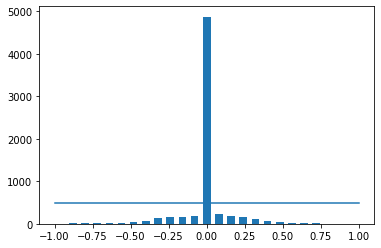

In [105]:
num_bins = 25
samples_per_bin = 500
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6543
removed : 4375
remaining 2168


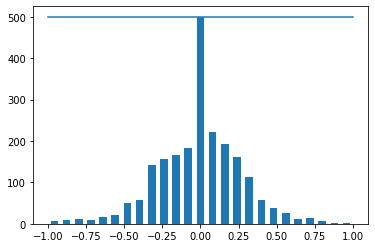

In [106]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed :', len(remove_list))
data.drop(data.index[remove_list], inplace= True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [107]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [108]:
X_train, X_validation, Y_train, Y_validation = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 4444)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_validation)))

Training Samples: 1734
Validation Samples: 434


Text(0.5, 1.0, 'Validation Set')

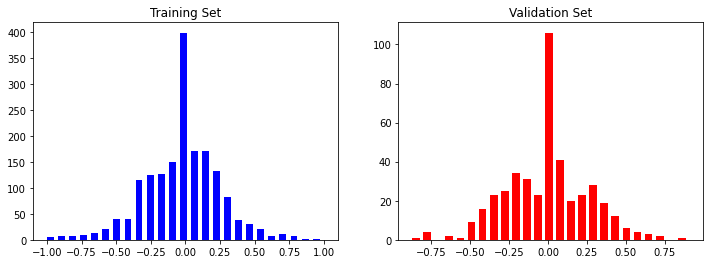

In [109]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(Y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training Set')
axes[1].hist(Y_validation, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation Set')

In [110]:
def zoom(image):
  zoom = iaa.Affine(scale= (1, 1.3))
  img = zoom.augment_image(image)
  return img

Text(0.5, 1.0, 'Zoomed Image')

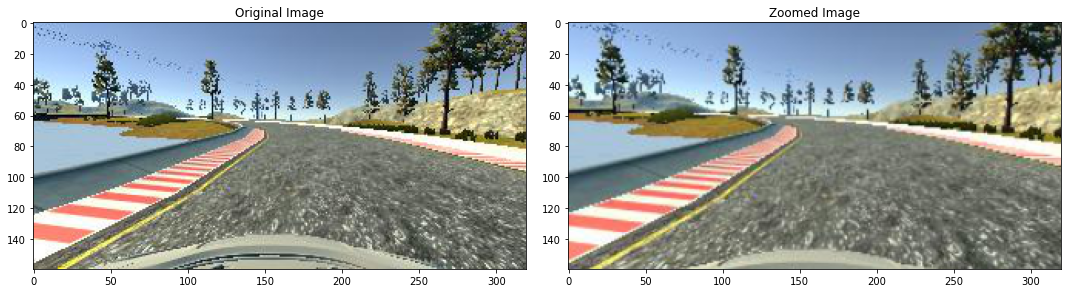

In [111]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [112]:
def pan(image):
  pan = iaa.Affine(translate_percent = {'x' : (-0.1, 0.1), 'y' : (-0.1,0.1)} )
  img = pan.augment_image(image)
  return img

Text(0.5, 1.0, 'Panned Image')

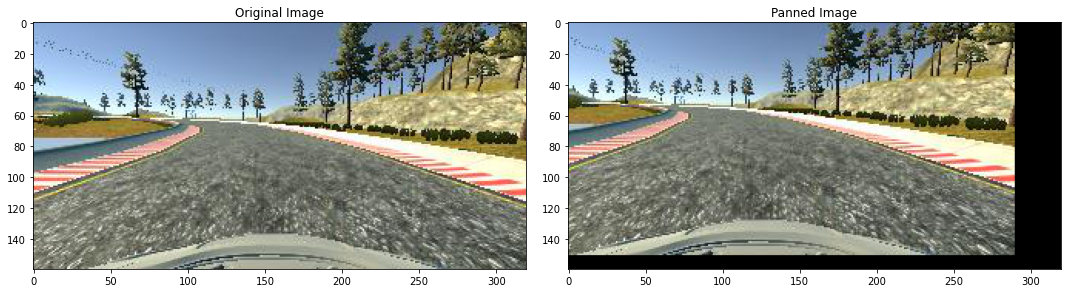

In [113]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [114]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  img = brightness.augment_image(image)
  return img

Text(0.5, 1.0, 'Multiplied Image')

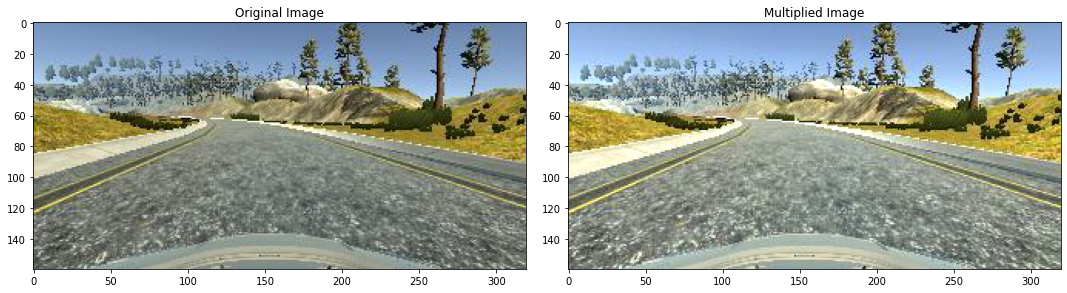

In [115]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
multiplied_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(multiplied_image)
axs[1].set_title('Multiplied Image')

In [116]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle: 0.0822444')

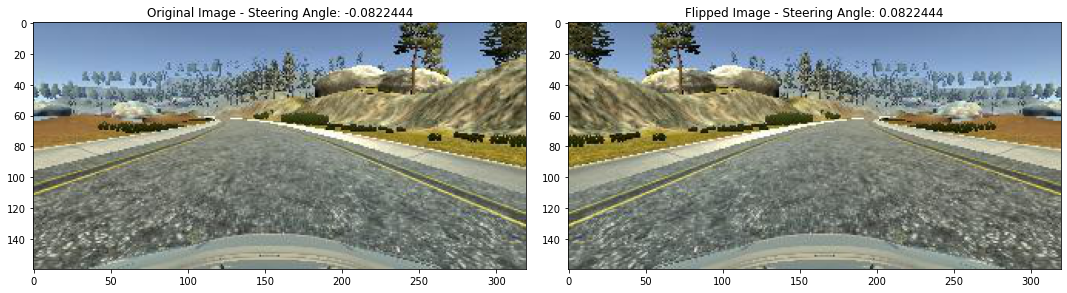

In [117]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - Steering Angle: ' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - Steering Angle: ' + str(flipped_steering_angle))

In [118]:
def random_augment(image_path, steering_angle):
  img = mpimg.imread(image_path)
  if np.random.rand() < 0.5:
    img = pan(img)

  if np.random.rand() < 0.5:
    img = zoom(img)

  if np.random.rand() < 0.5:
    img = img_random_brightness(img)

  if np.random.rand() < 0.5:
    img, steering_angle = img_random_flip(img, steering_angle)

  return img, steering_angle

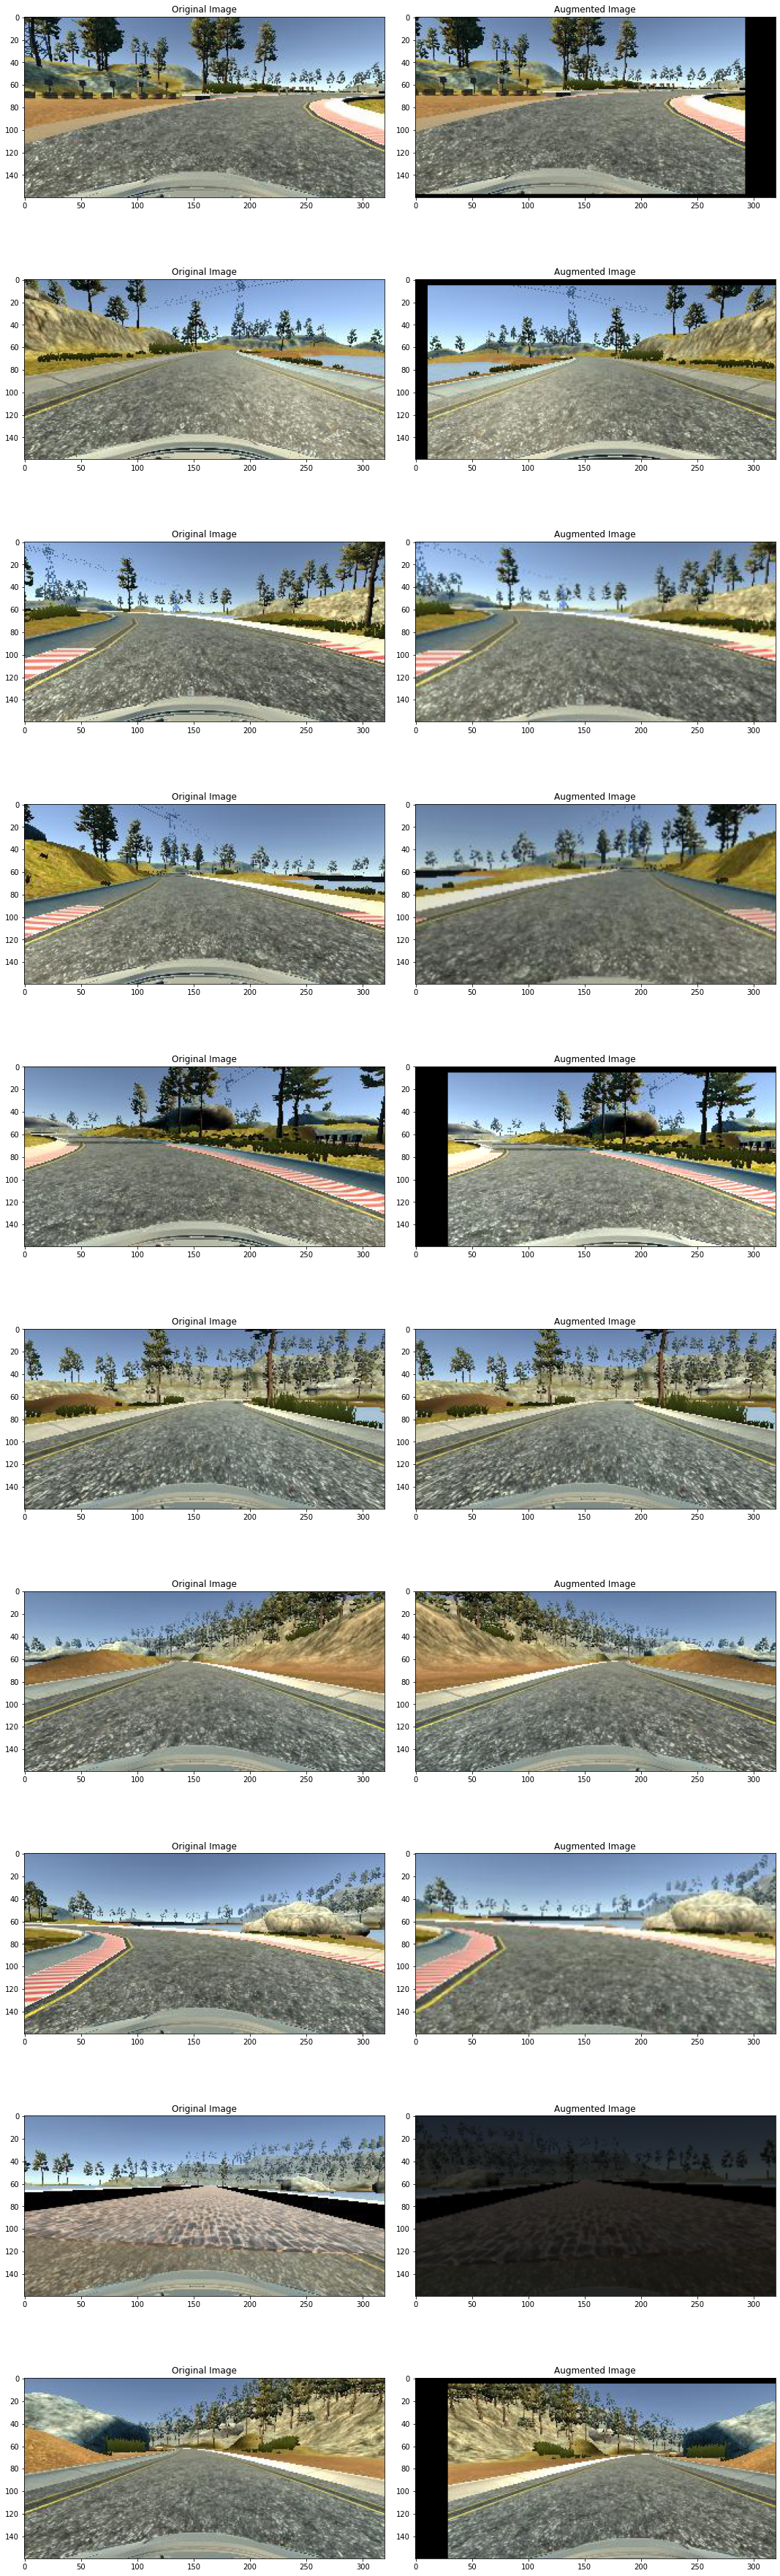

In [119]:
num_cols = 2
num_rows = 10

fig, axs = plt.subplots(num_rows, num_cols, figsize= (15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, augmented_steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [120]:
def img_preprocess(img):
  img = img[60:135, :,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

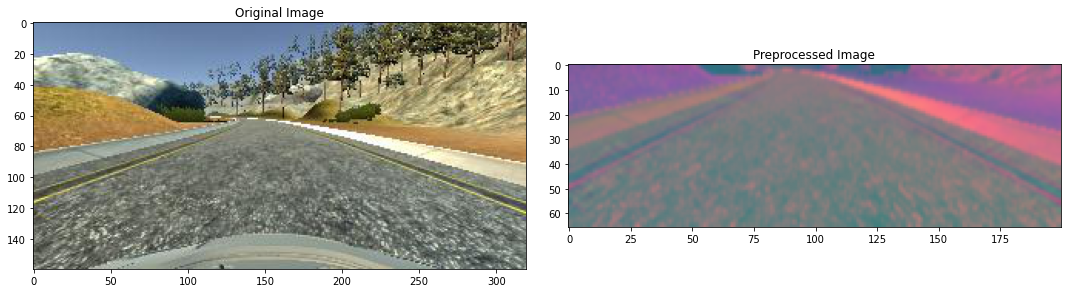

In [121]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axis = plt.subplots(1,2, figsize = (15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original Image')
axis[1].imshow(preprocessed_image)
axis[1].set_title('Preprocessed Image')

In [122]:
def batch_generator(image_paths, steering_angles, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if istraining:
        img, steering = random_augment(image_paths[random_index], steering_angles[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_angles[random_index]

      img = img_preprocess(img)
      batch_img.append(img)
      batch_steering.append(steering)

    yield (np.asarray(batch_img), np.asarray(batch_steering))


Text(0.5, 1.0, 'Validation Image')

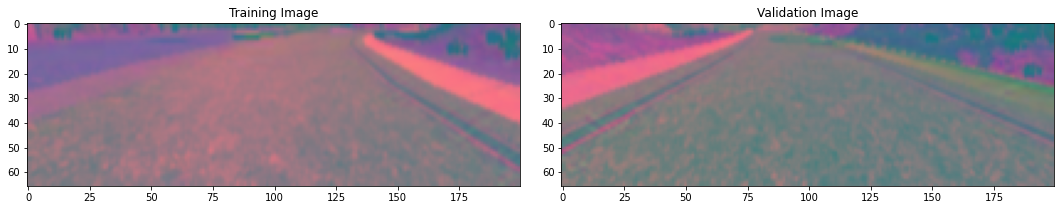

In [123]:
X_train_gen, Y_train_gen = next(batch_generator(X_train, Y_train, 1, 1))
X_validation_gen, Y_validation_gen = next(batch_generator(X_validation, Y_validation, 1, 0))

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(X_validation_gen[0])
axs[1].set_title('Validation Image')

In [124]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_validation = np.array(list(map(img_preprocess, X_validation)))

In [125]:
#plt.imshow(X_train[random.randint(0,len(X_train) -1)])
#plt.axis('off')
#print(X_train.shape)

In [126]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,  kernel_size=(5,5), strides = (2,2), input_shape = (66, 200, 3), activation = 'relu'))
  model.add(Convolution2D(36,  kernel_size=(5,5), strides = (2,2), activation = 'elu'))
  model.add(Convolution2D(48,  kernel_size=(5,5), strides = (2,2), activation = 'elu'))
  model.add(Convolution2D(64,  kernel_size=(3,3), activation = 'elu'))
  model.add(Convolution2D(64,  kernel_size=(3,3), activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer = Adam(learning_rate = 1e-4)
  model.compile(loss = 'mse', optimizer = optimizer)

  return model

In [127]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_3 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_3 (Flatten)         (None, 1152)             

In [128]:
history = model.fit_generator(batch_generator(X_train, Y_train, 100, 1), 
                              steps_per_epoch = 500, 
                              epochs = 10, 
                              validation_data = batch_generator(X_validation, Y_validation, 100, 0), 
                              validation_steps = 200, 
                              verbose = 1, 
                              shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
500/500 [==============================] - 644s 1s/step - loss: 0.0539 - val_loss: 0.0330
Epoch 2/10
500/500 [==============================] - 633s 1s/step - loss: 0.0418 - val_loss: 0.0323
Epoch 3/10
500/500 [==============================] - 634s 1s/step - loss: 0.0390 - val_loss: 0.0308
Epoch 4/10
500/500 [==============================] - 628s 1s/step - loss: 0.0374 - val_loss: 0.0346
Epoch 5/10
500/500 [==============================] - 629s 1s/step - loss: 0.0356 - val_loss: 0.0312
Epoch 6/10
500/500 [==============================] - 628s 1s/step - loss: 0.0354 - val_loss: 0.0326
Epoch 7/10
500/500 [==============================] - 638s 1s/step - loss: 0.0345 - val_loss: 0.0323
Epoch 8/10
500/500 [==============================] - 625s 1s/step - loss: 0.0336 - val_loss: 0.0305
Epoch 9/10
500/500 [==============================] - 630s 1s/step - loss: 0.0336 - val_loss: 0.0321
Epoch 10/10
500/500 [==============================] - 637s 1s/step - loss: 0.0329 - val_lo

Text(0.5, 0, 'Epoch')

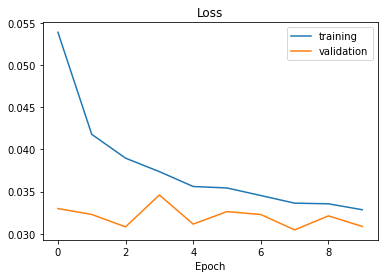

In [129]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [130]:
model.save('model.h5')

In [131]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>